# Program for statistical analysis (3rd step)
## This program runs over the data given by snap analysis. 
## Input

### * this program would need the documents: "wholeframestatistics.csv", "fluorstatistics.csv", "data.csv" and will work on the folders './autocorrelation/' and './autocorfixedperiods/'
### *If you want to compare some periods of time, you must to edit the array of snaps called 'referencesnap' in second box. Also you can put some anotations 

## Output

### This program will fit the cell lengths over time and will compute dinamically, the doubling time.
### Also it will be computed size and fluorescense distributions among some time intervals
### it will plot autocorrelation for mother's GFP and RFP 

In [85]:
%matplotlib inline
import cv2 #Image segmentation Library
import numpy as np #Numeric functions lib
from matplotlib import pyplot as plt #Basic ploting lib
import sys
import os #Lib for get the operative system sintaxis
from glob import glob #library used for get the file paths
import seaborn as sns #Library used for a nicer plotting
from sklearn import linear_model#Machine learning package for a smart plot fit
from sklearn import datasets
import pandas as pd#data analisys library
import scipy.stats

def indexes(y,thresh,peakdist):#peak detection algorithm
    dy = np.diff(y)
    ind = []
    for i in range(len(dy)):
        if len(ind) > 0:
            if dy[i] < dy[int(i-1)] and dy[i]<-thresh and i-peakdist>ind[-1]:
                ind.append(i)
        elif len(ind) == 0:
            if dy[i] < dy[int(i-1)] and dy[i]<-thresh:
                ind.append(i)
    return ind  

def getjointplot(x,y,df,name):
    if not os.path.exists('./jointplot'):
        os.makedirs('./jointplot')
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
    plot = sns.jointplot(x,y,df,size=8,linewidth=2,marginal_kws=dict(bins=25))
    plot.savefig('./jointplot/name')

In [153]:
referencesnap=[0,38,78,149]#each list element is the snap you have taken a reference in snap analysis
timebetweenframes=7
ref=[x*timebetweenframes for x in referencesnap]#each list element is the time (min) you will take a reference
anotation=['OD=0.0','OD=0.2','OD=0.38','']#each list element is te anotation you will include 
if not (len(referencesnap)+1>(len(anotation))):
    print("anotation and references does not ave aproppriate sizes")

## ploting the length vs time for all mothers and computing doubling times

In [154]:
#peak detection parameters
thresh =0.5 #the min change to consider point as a peak
peakdist = 3 # the min distance between two peaks

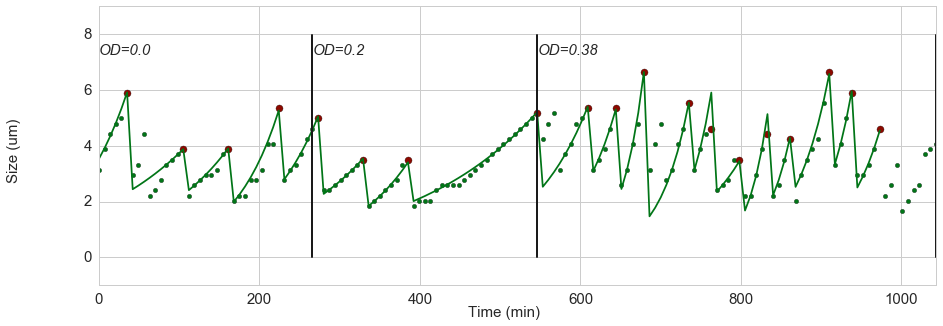

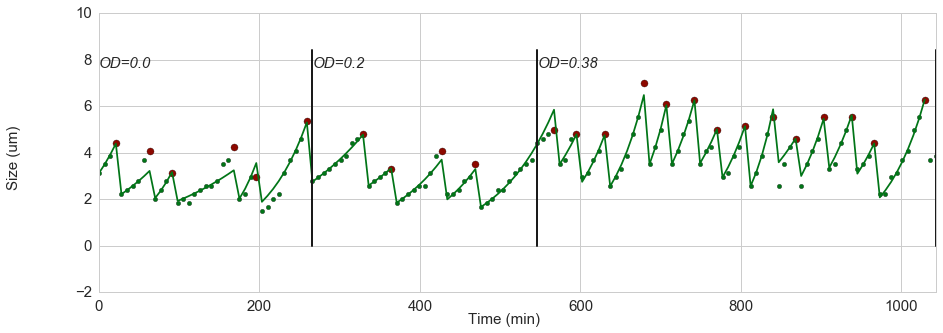

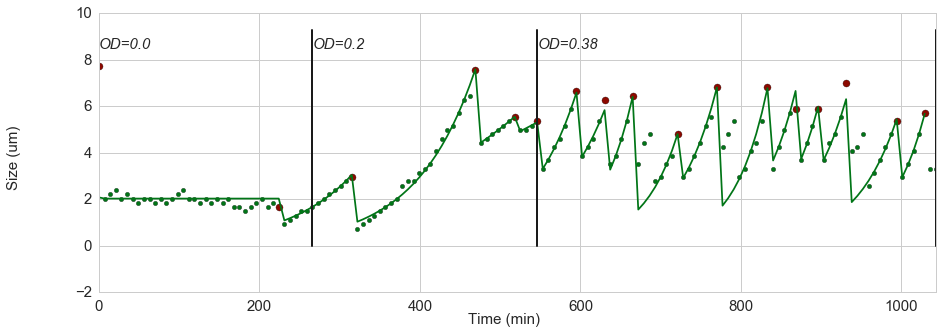

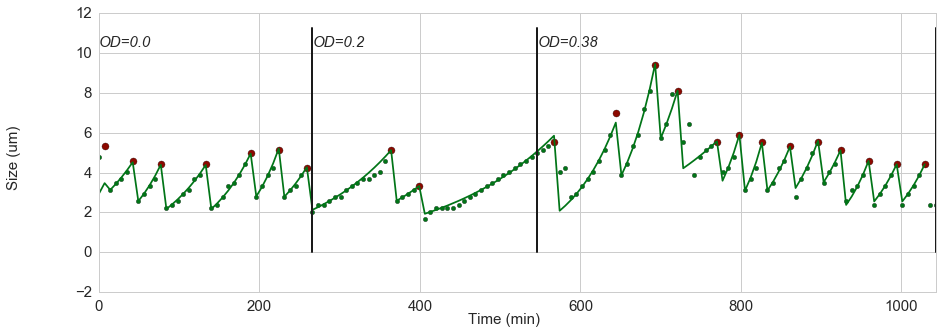

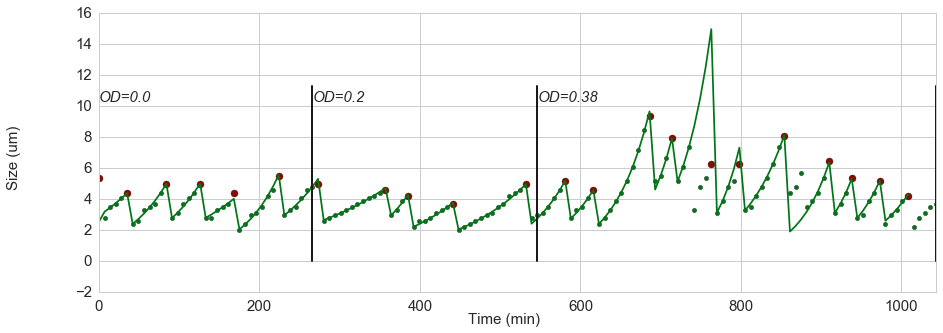

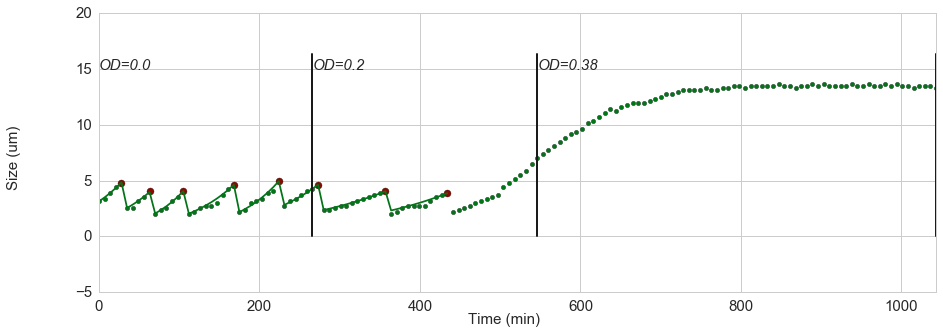

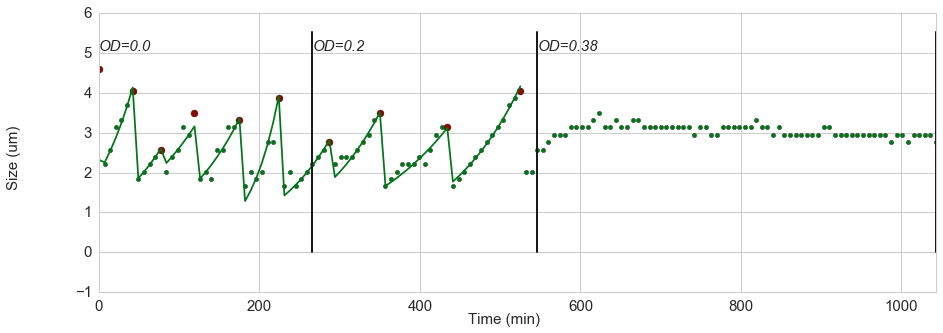

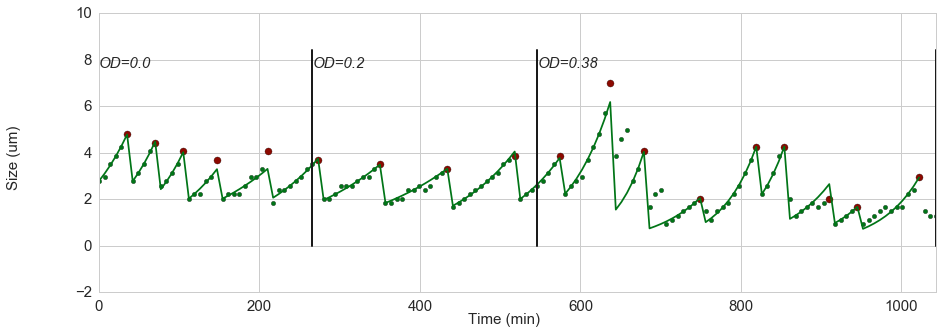

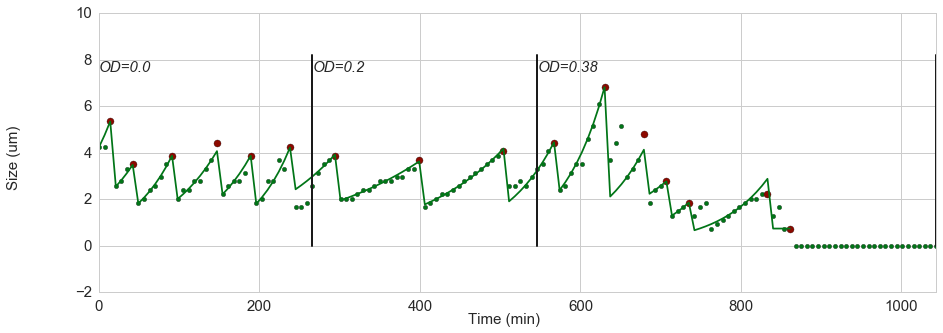

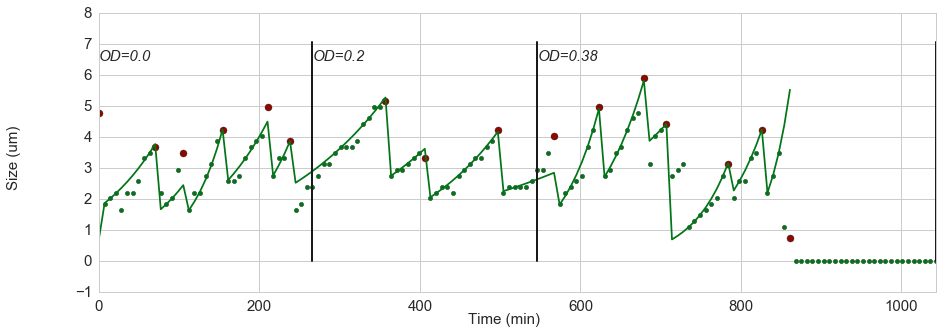

In [155]:
if not os.path.exists('./motherfluor'):
    os.makedirs('./motherfluor')
if not os.path.exists('./motherlen'):
    os.makedirs('./motherlen')
    
data = pd.read_csv('data.csv')    
motherarray = data['Mother'].unique()

motherlen = []
divisiontime = []
td = []

for i in motherarray:
    motherlen.append(data.query('Mother == '+str(i)))
doublings=np.zeros((len(motherlen[0]), len(motherlen)))
for i in motherarray:
    ln = motherlen[i]['Length(um)'].tolist()
    time = motherlen[i]['Time(min)'].tolist()
    lmax =[]
    lmin=[]

    timebetweenframes=time[2]-time[1]
    ind = indexes(ln,thresh, peakdist)
    tind=np.zeros(len(ind))
    fitl=[]
    fitt=[]
    for j in range(len(ind)):#counting over all peaks
        tind[j]=time[ind[j]]
        lmax.append(ln[ind[j]])
        lmin.append(ln[ind[j]+1])
        if(j>0):
            d=float(time[ind[j]]-time[ind[j-1]])#division time
            tt=ind[j-1]+1#temporaltime
        else:
            d=float(time[ind[j]]-time[0])
            tt=0
        dt=[]#array of log(len)
        tm=[]
        results=[]
        temp=0
        while(tt<=ind[j]):
            dt.append(np.log2(ln[tt]))
            tm.append(temp)
            temp=temp+timebetweenframes
            tt=tt+1
        if(len(dt)>2):#guarantees there is enought data
            tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
            model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
            model_ransac.fit(tm, dt)#smart fit
            a=1/model_ransac.estimator_.coef_#growth rate
            divisiontime.append(d)
            td.append([a,d])
            l0=2**(model_ransac.estimator_.intercept_)
        if(j>0):
            tt=ind[j-1]+1#temporaltime
            while(tt<=ind[j]):
                doublings[tt][i] = a[0]
                fitl.append(l0*2**((-time[ind[j-1]+1]+time[tt])/a[0]))
                fitt.append(time[tt])
                tt=tt+1   
        else:
            tt=0 
            while(tt<=ind[j]):
                doublings[tt][i] = a[0]
                fitl.append(l0*2**(time[tt]/a[0]))
                fitt.append(time[tt])
                tt=tt+1 
    median=np.zeros(len(doublings))
    std=np.zeros(len(doublings))
    for i in range(len(doublings)):
        temp=[]
        for j in range (len(doublings[i])):
            if not(doublings[i][j]==0):
                temp.append(doublings[i][j])        
        if(len(temp)>1):
            median[i]=np.median(temp)
            for k in range (len(temp)):
                stt=abs(temp[k]-median[i])
                if(stt<50):
                    std[i]+=stt/len(temp)
            
    fig, ax = plt.subplots(1, 1, figsize=(15, 5),sharex=True)
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=5, color_codes=False, rc=None)
    sns.axes_style('whitegrid')
    ax.plot(fitt,fitl,c = 'g')
    ax.scatter(time,ln,c = 'g',s = 20)
    y=[0]*len(tind)
    ax.scatter(tind,lmax, c='r', s=50 )
    ax.set_xlim([time[0], time[len(time)-1]])
    for m in range(len(ref)):
        ax.plot([ref[m], ref[m]], [0,1.2*np.max(ln)], 'k-', lw=2)
        ax.text(ref[m], 1.1*np.max(ln), anotation[m], style='italic',fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
    fig.text(0.04, 0.5, 'Size (um)',fontsize=15, va='center', rotation='vertical')
    plt.savefig('./motherlen/mother'+str(i)+'.png')    

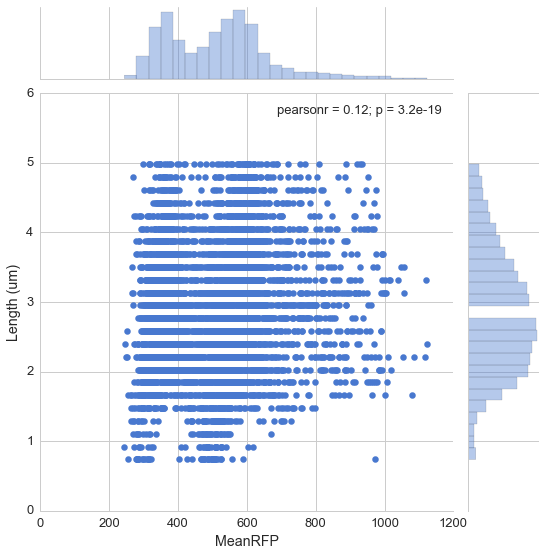

In [156]:
data = pd.read_csv("wholeframestatistics.csv")
getjointplot('MeanRFP','Length (um)',data,'totalRFPvslength.png')

there is no GFP in your data


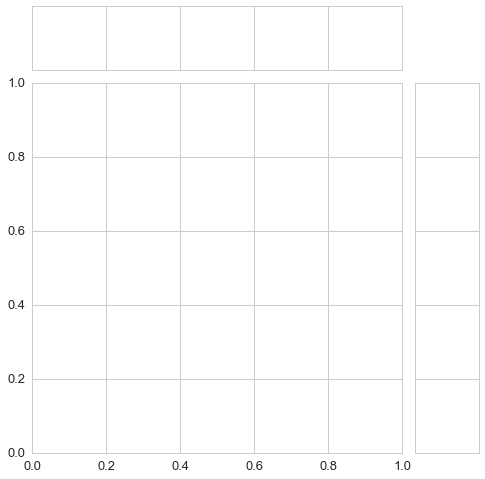

In [157]:
try:    
    data = pd.read_csv("wholeframestatistics.csv")
    getjointplot('MeanGFP','Length (um)',data,'totalGFPvslength.png')
except:
    print('there is no GFP in your data')

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


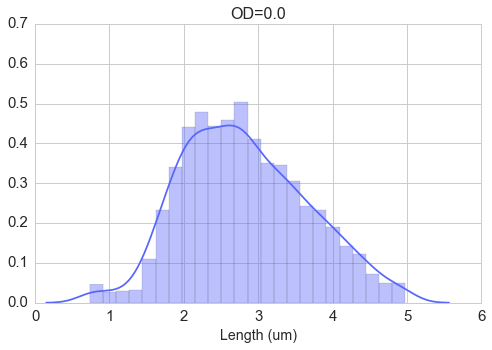

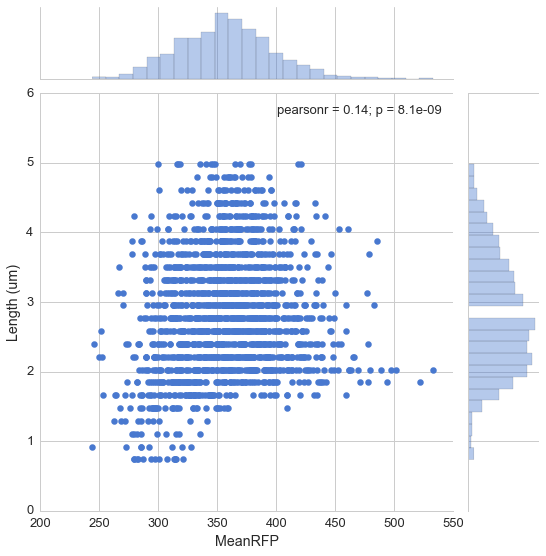

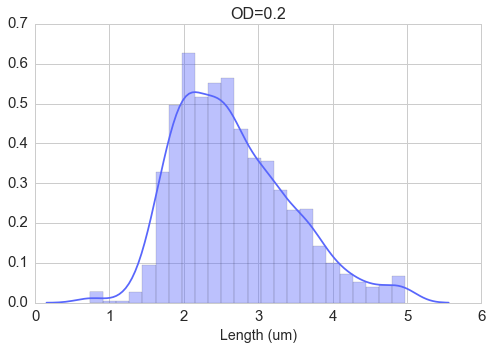

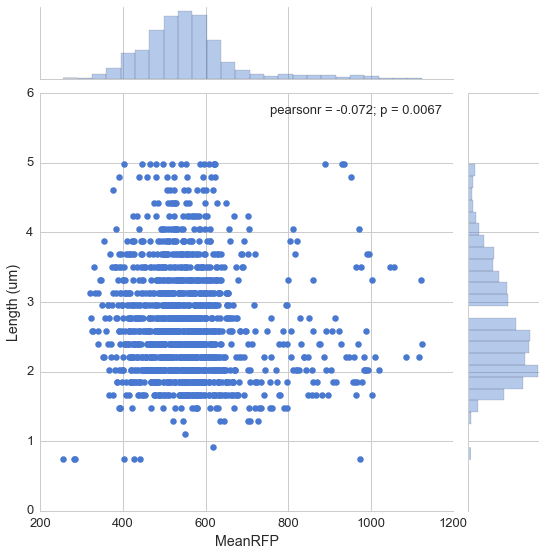

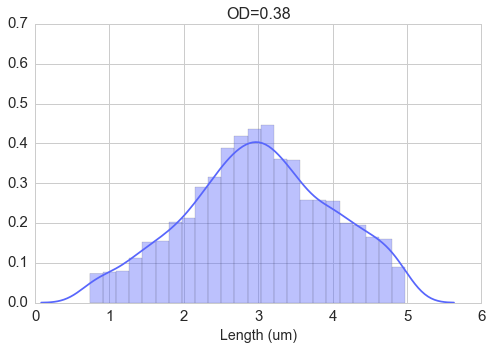

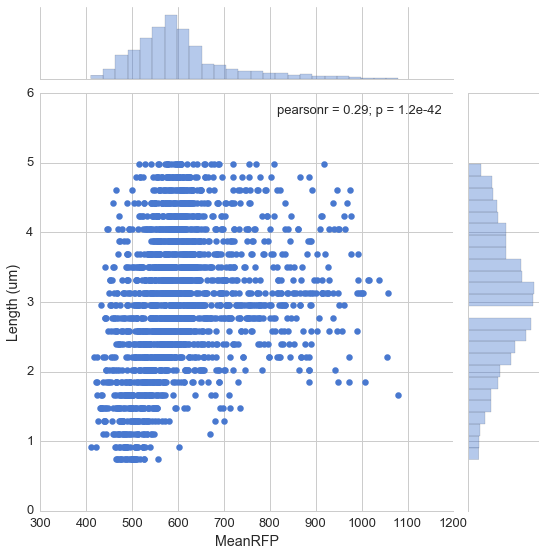

In [158]:
data = pd.read_csv("wholeframestatistics.csv")
if not os.path.exists('./lendistributions'):
    os.makedirs('./lendistributions')
for i in range (1,len(ref)):
    timex=data[data['time(min)'] <ref[i]]
    timex=timex[timex['time(min)']>ref[i-1]]
    fl = timex['Length (um)'].tolist()
    fl = pd.Series(fl, name="Length (um)")
    fig, ax = plt.subplots(1,1, figsize=(8, 5),sharex=True)
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
    sns.distplot(fl,bins=24,color="#5866FC")
    ax.set_ylim([0,0.7])
    ax.set_xlim([0,6])
    ax.set_title(anotation[i-1],fontsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.figure.savefig('./lendistributions/'+anotation[i-1]+'('+str(ref[i])+'-'+str(ref[i])+').png')
    getjointplot('MeanRFP','Length (um)',timex,'MeanRFPvsLength'+str(anotation[i-1])+'.png')

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


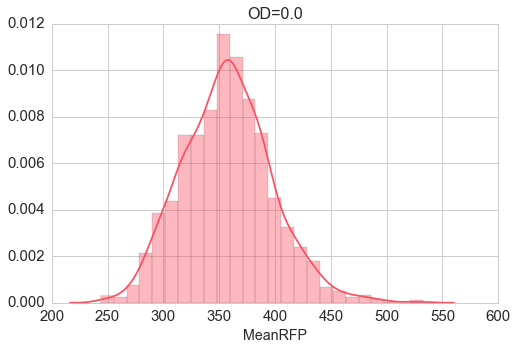

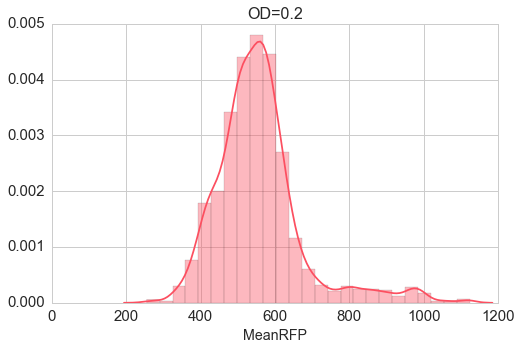

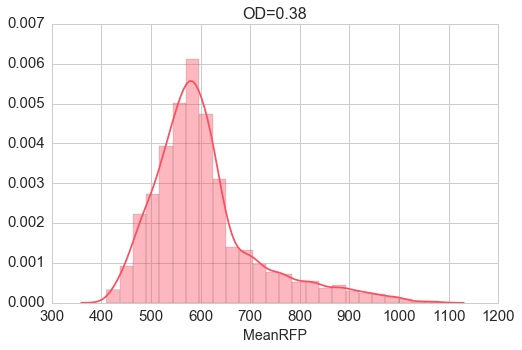

In [159]:
data = pd.read_csv("wholeframestatistics.csv")
if not os.path.exists('./fluordistributions'):
    os.makedirs('./fluordistributions')
for i in range (1,len(ref)):
    timex=data[data['time(min)'] <ref[i]]
    timex=timex[timex['time(min)']>ref[i-1]]
    fl = timex['MeanRFP'].tolist()
    flR= pd.Series(fl, name="MeanRFP")
    try:
        flG = timex['MeanGFP'].tolist()
        flG= pd.Series(fl, name="MeanGFP")
    except:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5),sharex=True)
        sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
        sns.distplot(flR,bins=25,color="#FC4F60")
        ax.set_title(anotation[i-1],fontsize=16)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        plt.savefig('./fluordistributions/RFP'+anotation[i-1]+'('+str(ref[i])+'-'+str(ref[i])+').png')
    else:
        getjointplot('MeanRFP','MeanGFP',fl,'MeanRFPvsMeanGFP'+anotation[i-1]+'('+str(ref[i])+'-'+str(ref[i])+').png')
        flG
        fig, ax = plt.subplots(1, 1, figsize=(8, 5),sharex=True)
        sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
        sns.distplot(flR,bins=25,color="#FC4F60")
        ax.set_title(str(anotation[i-1]),fontsize=16)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        plt.savefig('./fluordistributions/RFP'+anotation[i-1]+'('+str(ref[i])+'-'+str(ref[i])+').png')
                     
        fig, ax = plt.subplots(1, 1, figsize=(8, 5),sharex=True)
        sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
        sns.distplot(flG,bins=25,color="#0DA102")
        ax.set_title(str(anotation[i-1]),fontsize=16)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        plt.savefig('./fluordistributions/GFP'+anotation[i-1]+'('+str(ref[i])+'-'+str(ref[i])+').png')

there is no GFP in your data


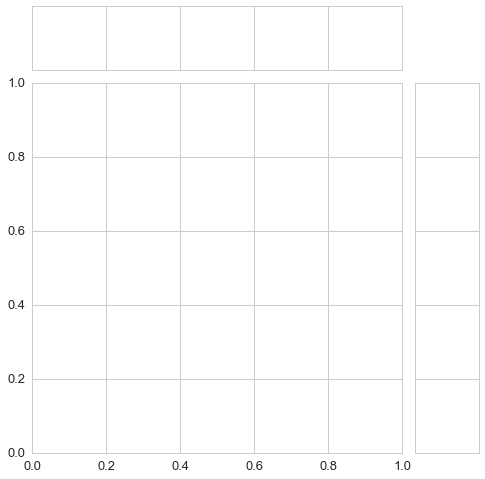

In [160]:
try: 
    data = pd.read_csv("wholeframestatistics.csv")
    getjointplot('MeanRFP','MeanGFP',data,'TOTALMeanRFPvsMeanGFP.png')
except:
    print('there is no GFP in your data')

## Average doubing time dynamics

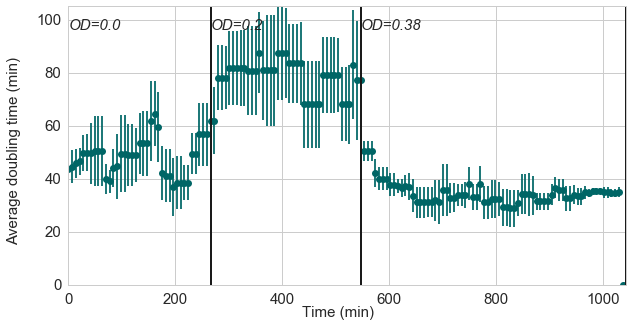

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=5, color_codes=False, rc=None)
sns.axes_style('whitegrid')
#ax.scatter(time,std, c='r', s=50 )
ax.errorbar(time, median, yerr=std, fmt='o',c='#006666')
ax.set_ylim([0,1.2*np.max(median)])
ax.set_xlim([time[0], time[len(time)-1]])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
for m in range(len(ref)):
    ax.plot([ref[m], ref[m]], [0,1.2*np.max(median)], 'k-', lw=2)
    ax.text(ref[m], 1.1*np.max(median), anotation[m], style='italic',fontsize=15)
fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
fig.text(0.04, 0.5, 'Average doubling time (min)',fontsize=15, va='center', rotation='vertical')
plt.savefig('doublingtime.png')
f = open("./doublingtime.csv", "w")#Opens and then closes the file in order to erase all previous values
f.close()
f = open("./doublingtime.csv", "w")#opens the empty file 
f.write("time(min),Median doubling time(min)"+"\n")
for j in range (len(time)):
    f.write(str(time[j])+","+str(median[j])+"\n")
f.close()

## Mother fluorescence ploting

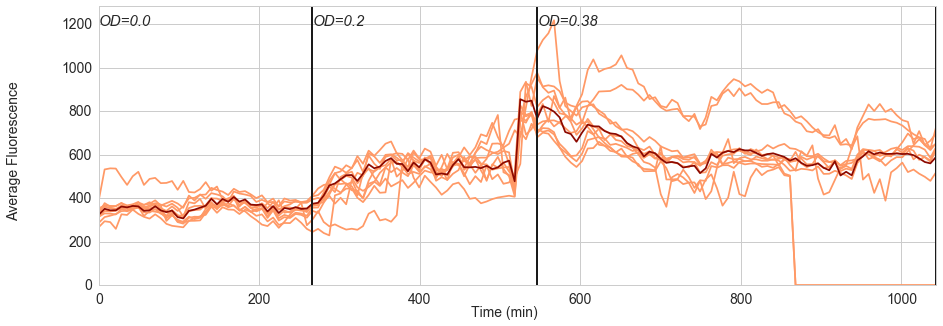

In [162]:
if not os.path.exists('./fluorstatistics'):
    os.makedirs('./fluorstatistics')
data = pd.read_csv('data.csv')
datafluor = pd.read_csv('fluorstatistics.csv')
try:
    gfpfl = datafluor['AverageGFP'].tolist()
except:
    timefl = datafluor['time(min)'].tolist()
    rfpfl = datafluor['AverageRFP'].tolist()
    motherfl = []
    motherarray = data['Mother'].unique()
    for i in motherarray:
        motherfl.append(data.query('Mother == '+str(i)))
        
    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    sns.set(style='whitegrid', palette='dark', font='sans-serif', font_scale=3, color_codes=True, rc=None)
    sns.axes_style('whitegrid')
    for i in motherarray:
        rfl = motherfl[i]['MeanRFP'].tolist()
        time = motherfl[i]['Time(min)'].tolist()
        ax.plot(time,rfl,c = '#ff9966')
    ax.set_xlim([time[0], time[len(time)-1]])
    ax.plot(time,rfpfl,c = 'r')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlim([time[0], time[len(time)-1]])
    ax.set_ylim(0, 1.5*np.max(rfpfl))
    for m in range(len(ref)):
        ax.plot([ref[m], ref[m]], [0,1.5*np.max(rfpfl)], 'k-', lw=2)
        ax.text(ref[m], 1.4*np.max(rfpfl), anotation[m], style='italic',fontsize=15)
    fig.text(0.5, 0.04, 'Time (min)',fontsize=14, ha='center')
    fig.text(0.04, 0.5, 'Average Fluorescence',fontsize=14, va='center', rotation='vertical')
    plt.savefig('./fluorstatistics/fluorescenseRFP.png')
else:
    timefl = datafluor['time(min)'].tolist()
    rfpfl = datafluor['AverageRFP'].tolist()
    noiserfp = datafluor['RFP CV'].tolist()
    motherfl = []
    motherarray = data['Mother'].unique()
    for i in motherarray:
        motherfl.append(data.query('Mother == '+str(i)))
        
    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    sns.set(style='whitegrid', palette='dark', font='sans-serif', font_scale=3, color_codes=True, rc=None)
    sns.axes_style('whitegrid')
    for i in motherarray:
        rfl = motherfl[i]['MeanRFP'].tolist()
        gfl = motherfl[i]['MeanGFP'].tolist()        
        time = motherfl[i]['Time(min)'].tolist()
        ax[0].plot(time,rfl,c = '#ff9966')
        ax[1].plot(time,gfl,c = '#33ff33')
    
    ax[0].plot(time,rfpfl,c = 'r')
    ax[1].plot(time,gfpfl,c = 'g') 
    ax[0].tick_params(axis='x', labelsize=14)
    ax[0].tick_params(axis='y', labelsize=14)
    ax[1].tick_params(axis='x', labelsize=14)
    ax[1].tick_params(axis='y', labelsize=14)
    ax[0].set_xlim([time[0], time[len(time)-1]])
    ax[1].set_xlim([time[0], time[len(time)-1]])
    ax[0].set_ylim(0, 1.5*np.max(rfpfl))
    ax[1].set_ylim(0, 1.5*np.max(gfpfl))
    for m in range(len(ref)):
        ax[0].plot([ref[m], ref[m]], [0,1.5*np.max(gfpfl)], 'k-', lw=2)
        ax[1].plot([ref[m], ref[m]], [0,1.5*np.max(gfpfl)], 'k-', lw=2)
        ax[0].text(ref[m], 1.4*np.max(gfpfl), anotation[m], style='italic',fontsize=15)
        ax[1].text(ref[m], 1.4*np.max(gfpfl), anotation[m], style='italic',fontsize=15)
    fig.text(0.5, 0.04, 'Time (min)',fontsize=14, ha='center')
    fig.text(0.04, 0.5, 'Average Fluorescence',fontsize=14, va='center', rotation='vertical')
    ax[0].figure.savefig('./fluorstatistics/fluorescenseRFP.png')
    ax[1].figure.savefig('./fluorstatistics/fluorescenseGFP.png')

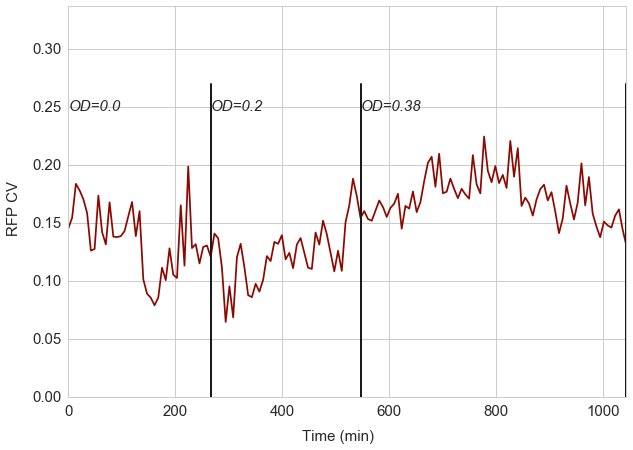

In [163]:
plt.clf()
if not os.path.exists('./fluorstatistics'):
    os.makedirs('./fluorstatistics')
datafluor = pd.read_csv('fluorstatistics.csv')
noiserfp = datafluor['RFP CV'].tolist()
time = datafluor['time(min)'].tolist()
try:
    noisegfp = datafluor['GFP CV'].tolist()
except:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7),sharex=True)
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=5, color_codes=False, rc=None)
    sns.axes_style('whitegrid')
    ax.plot(time,noiserfp,c = 'r')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    for m in range(len(ref)):
        ax.plot([ref[m], ref[m]], [0,1.2*np.max(noiserfp)], 'k-', lw=2)
        ax.text(ref[m], 1.1*np.max(noiserfp), anotation[m], style='italic',fontsize=15)
    ax.set_xlim([time[0], time[len(time)-1]])  
    ax.set_ylim([0,1.5*np.max(noiserfp)])
    fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
    fig.text(0.04, 0.5, 'RFP CV',fontsize=15, va='center', rotation='vertical')
    plt.savefig('./fluorstatistics/noiseRFP.png')
else:
    fig, ax = plt.subplots(1, 2, figsize=(10, 7),sharex=True)
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=5, color_codes=False, rc=None)
    sns.axes_style('whitegrid')
    ax[0].plot(time,noiserfp,c = 'r')
    ax[1].plot(time,noisegfp,c = 'g')
    ax[0].tick_params(axis='x', labelsize=15)
    ax[0].tick_params(axis='y', labelsize=15)
    ax[1].tick_params(axis='x', labelsize=15)
    ax[1].tick_params(axis='y', labelsize=15)
    for m in range(len(ref)):
        ax[0].plot([ref[m], ref[m]], [0,1.2*np.max(noiserfp)], 'k-', lw=2)
        ax[0].text(ref[m], 1.1*np.max(noiserfp), anotation[m], style='italic',fontsize=15)
        ax[1].plot([ref[m], ref[m]], [0,1.2*np.max(noisegfp)], 'k-', lw=2)
        ax[1].text(ref[m], 1.1*np.max(noisegfp), anotation[m], style='italic',fontsize=15)
    ax[0].set_xlim([time[0], time[len(time)-1]])  
    ax[0].set_ylim([0,1.5*np.max(noiserfp)])    
    ax[1].set_xlim([time[0], time[len(time)-1]])  
    ax[1].set_ylim([0,1.5*np.max(noisegfp)])
    fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
    fig.text(0.04, 0.5, 'RFP CV',fontsize=15, va='center', rotation='vertical')
    ax[0].figure.savefig('./fluorstatistics/noiseRFP.png')
    ax[1].figure.savefig('./fluorstatistics/noiseRFP.png')

## Autocorrelation ploting

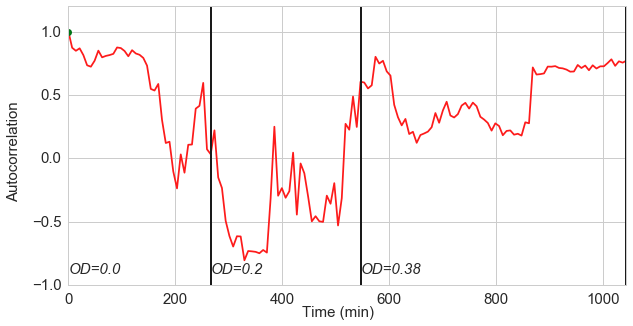

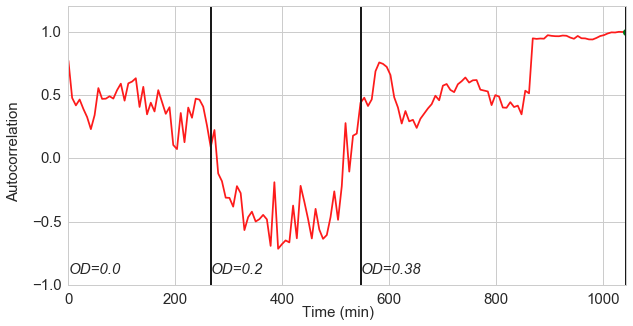

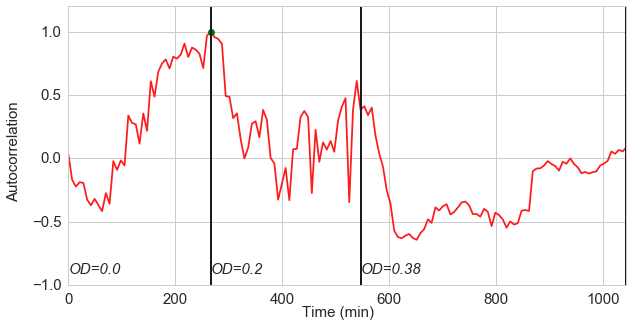

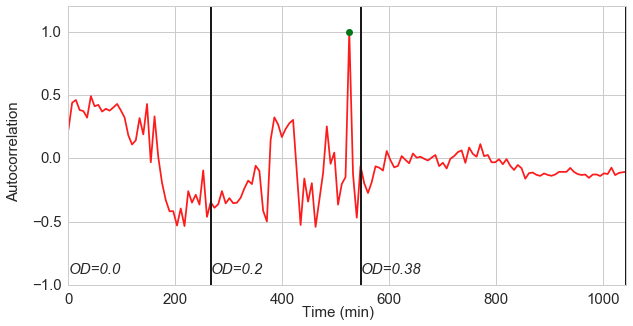

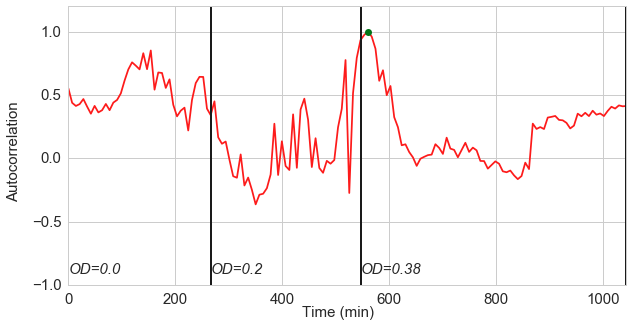

In [167]:
files=[]
pattern="*.csv"
dir='./autocorrelation/'
for dir,_,_ in os.walk(dir):
    files.extend(glob(os.path.join(dir,pattern)))
filenames = next(os.walk(dir))[2]
for i in range(0,len(files)):     
    file = files[i]
    time=[]
    autocorrR=[]
    datacorr = pd.read_csv(file)
    try:
        autocorrG = datacorr['GFP Autocorr'].tolist()
    except:    
        time = datacorr['time(min)'].tolist()
        autocorrR = datacorr['RFP Autocorr'].tolist()
        point = datacorr['Snap reference'].tolist()    
        fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
        sns.set(style='whitegrid', palette='dark', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
        sns.axes_style('whitegrid')
        ax.plot(time,autocorrR,c='#FD1B1B')
        ax.plot(point[0], [1], 'o',c='g')
        ax.set_xlim([time[0], time[len(time)-1]])  
        ax.set_ylim([-1,1.2]) 
        for m in range(len(ref)):
            ax.plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
            ax.text(ref[m], -0.9, anotation[m], style='italic',fontsize=15)
        fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
        fig.text(0.04, 0.5, 'Autocorrelation',fontsize=15, va='center', rotation='vertical')
        ax.figure.savefig('./autocorrelation/RFPwith'+str(point[0])+'.png')
    else:    
        time = datacorr['time(min)'].tolist()
        autocorrR = datacorr['RFP Autocorr'].tolist()
        point = datacorr['Snap reference'].tolist()
    
        fig, ax = plt.subplots(2, 1, figsize=(10, 5),sharex=True)
        sns.set(style='whitegrid', palette='dark', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
        sns.axes_style('whitegrid')
        for m in range(len(ref)):
            ax[0].plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
            ax[0].text(ref[m], -0.9, anotation[m], style='italic',fontsize=15)
            ax[1].plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
            ax[1].text(ref[m], -0.9, anotation[m], style='italic',fontsize=15)
        ax[0].set_xlim([time[0], time[len(time)-1]])  
        ax[0].set_ylim([-1,1.2]) 
        ax[1].set_xlim([time[0], time[len(time)-1]])  
        ax[1].set_ylim([-1,1.2])
        ax[0].plot(time,autocorrR,c='#FD1B1B')
        ax[1].plot(time,autocorrG,c='#0DA102')
        ax[0].plot(point[0], [1], 'o',c='g')
        ax[1].plot(point[0], [1], 'o',c='r')
        fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
        fig.text(0.04, 0.5, 'Autocorrelation',fontsize=15, va='center', rotation='vertical')
        ax[0].figure.savefig('./autocorrelation/RFPautwith'+point[0]+'.png')
        ax[1].figure.savefig('./autocorrelation/GFPautwith'+point[0]+'.png')

## Autocorrelation whith fixed periods

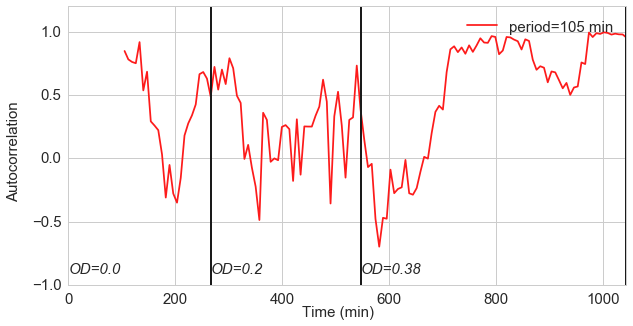

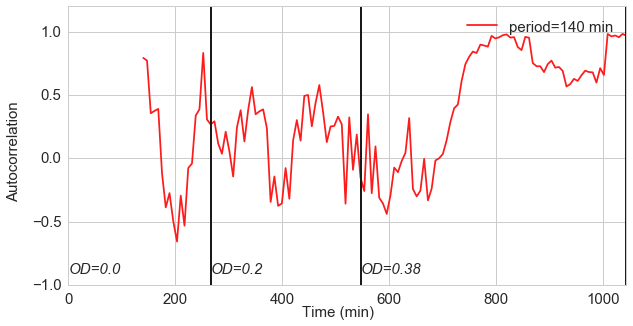

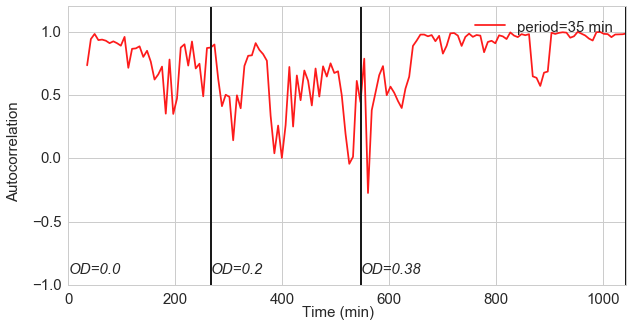

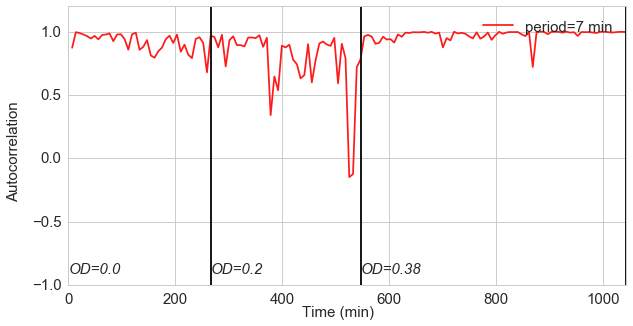

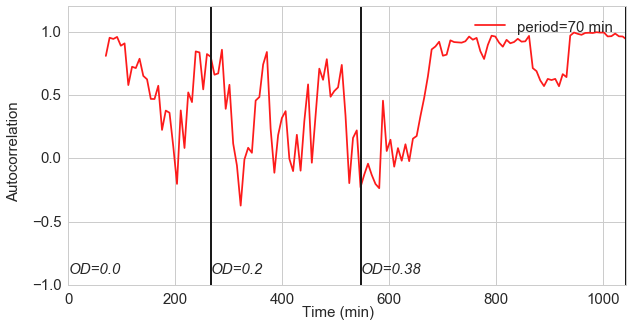

In [165]:
files=[]
pattern="*.csv"
dir='./autocorrfixedperiods'
for dir,_,_ in os.walk(dir):
    files.extend(glob(os.path.join(dir,pattern)))
for i in range(0,len(files)):     
    file = files[i]
    time=[]
    autocorrR=[]
    datacorr = pd.read_csv(file)
    try:
        autocorrG = datacorr['GFP Autocorr'].tolist()
    except:    
        time = datacorr['time(min)'].tolist()
        autocorrR = datacorr['RFP Autocorr'].tolist()
        name = datacorr['Period'].tolist()    
        fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
        sns.set(style='whitegrid', palette='dark', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
        sns.axes_style('whitegrid')
        ax.plot(time,autocorrR,c='#FD1B1B',label='period='+str(name[0])+' min')
        #ax.plot(point[0], [1], 'o',c='g')
        ax.legend()
        ax.set_xlim([0, time[len(time)-1]])  
        ax.set_ylim([-1,1.2]) 
        for m in range(len(ref)):
            ax.plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
            ax.text(ref[m], -0.9, anotation[m], style='italic',fontsize=15)
        fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
        fig.text(0.04, 0.5, 'Autocorrelation',fontsize=15, va='center', rotation='vertical')
        ax.figure.savefig('./autocorrfixedperiods/RFPwithperiof'+str(name[0])+'.png')
    else:    
        time = datacorr['time(min)'].tolist()
        autocorrR = datacorr['RFP Autocorr'].tolist()
        point = datacorr['Snap reference'].tolist()
    
        fig, ax = plt.subplots(2, 1, figsize=(10, 5),sharex=True)
        sns.set(style='whitegrid', palette='dark', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
        sns.axes_style('whitegrid')
        for m in range(len(ref)):
            ax[0].plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
            ax[0].text(ref[m], -0.9, anotation[m], style='italic',fontsize=15)
            ax[1].plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
            ax[1].text(ref[m], -0.9, anotation[m], style='italic',fontsize=15)
        ax[0].set_xlim([time[0], time[len(time)-1]])  
        ax[0].set_ylim([-1,1.2]) 
        ax[1].set_xlim([time[0], time[len(time)-1]])  
        ax[1].set_ylim([-1,1.2])
        ax[0].plot(time,autocorrR,c='#FD1B1B')
        ax[1].plot(time,autocorrG,c='#0DA102')
        ax[0].plot(point[0], [1], 'o',c='g')
        ax[1].plot(point[0], [1], 'o',c='r')
        fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
        fig.text(0.04, 0.5, 'Autocorrelation',fontsize=15, va='center', rotation='vertical')
        ax[0].figure.savefig('./autocorrfixedperiods/RFPwithperiof'+str(name[0])+'.png')
        ax[1].figure.savefig('./autocorrfixedperiods/GFPwithperiof'+str(name[0])+'.png')

## Doubling time weighted averaging

In [166]:
ave=0
totalt=0
for i in range (len(divisiontime)):
    totalt+=divisiontime[i]
n=0
for i in range (len(td)):
    if(td[i][0]>10 and td[i][0]<500):
        ave+=td[i][0]*td[i][1]/totalt
        n+=1
averagetd=ave
std=0
for i in range (len(td)):
    if(td[i][0]>0 and td[i][0]<500):
        std+=(td[i][0]-ave)**2
errortd=np.sqrt(std/n)
averagediv=np.median(divisiontime)
errordiv=np.std(divisiontime)           
f = open("meanvalues.csv", "w")#abre y cierra en modo escritura para borrar lo que tenga adentro
f.close()
f = open("meanvalues.csv", "w")
f.write("average doubling time,"+str(float(averagetd))+"\n")
f.write("std doubling time,"+str(float(errortd))+"\n")
f.write("average division time,"+str(averagediv)+"\n")
f.write("std division time,"+str(errordiv)+"\n")
f.close()